In [38]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem import PorterStemmer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
df1 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv")
df2 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv")
df3 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv")
df4 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv")
df5 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv")
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.head()

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [40]:
df = df[['content', 'category']]
df = df.rename(columns = {'category':'labels','content':'data'})

In [41]:
X = df['data']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [42]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
stemmer = PorterStemmer()

In [47]:
def get_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [48]:
class MyTokenizer:
     def __init__(self):
         self.some_args = None
        
     def __call__(self, text):
        
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [stemmer.stem(word) for word in tokens]
        #tokens = [lemmatizer.lemmatize(word, pos=get_pos(tag)) for word, tag in nltk.pos_tag(tokens)]

        return tokens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=MyTokenizer(), stop_words="english")

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [50]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 717216 stored elements and shape (8000, 49646)>

In [51]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(8000)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [52]:
pca.explained_variance_ratio_.sum()

1.0

In [53]:
import numpy as np

np.where(pca.explained_variance_ratio_.cumsum() >= 0.9)

(array([4058, 4059, 4060, ..., 7997, 7998, 7999]),)

In [54]:
X_train.shape

(8000, 8000)

In [55]:
(X_train == 0).sum()

41

In [56]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight="balanced")

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [57]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.96      0.97      0.97       400
    education       0.99      0.98      0.98       400
entertainment       0.99      0.99      0.99       400
       sports       0.99      0.99      0.99       400
   technology       0.96      0.95      0.96       400

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000



[]

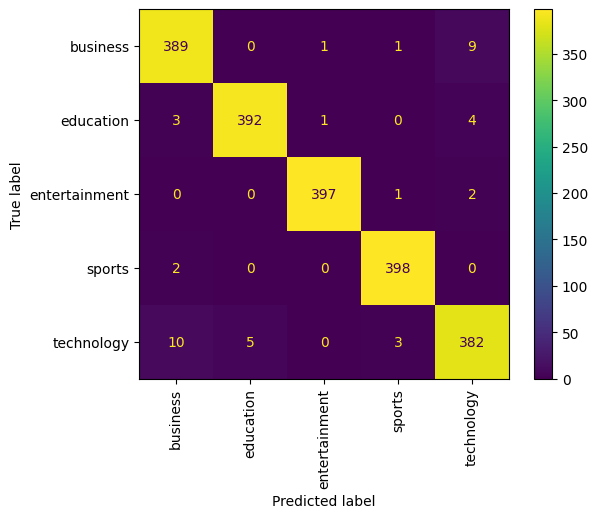

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=90)
plt.plot()

In [59]:
from sklearn.pipeline import Pipeline

final_model = Pipeline(steps=[
    ('vectorizer', vectorizer),
    ('pca', pca),
    ('model', model)
])

final_model

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<__main__.MyTokenizer object at 0x7d2d4aeb00a0>)),
                ('pca', TruncatedSVD(n_components=8000)),
                ('model', LogisticRegression(class_weight='balanced'))])

[]

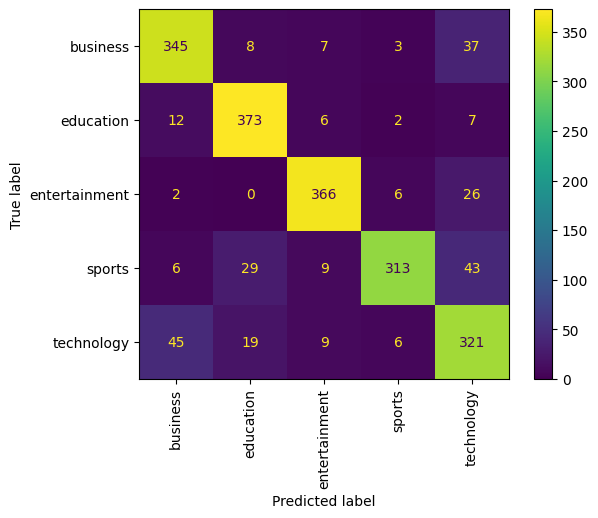

In [60]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=90)
plt.plot()

[]

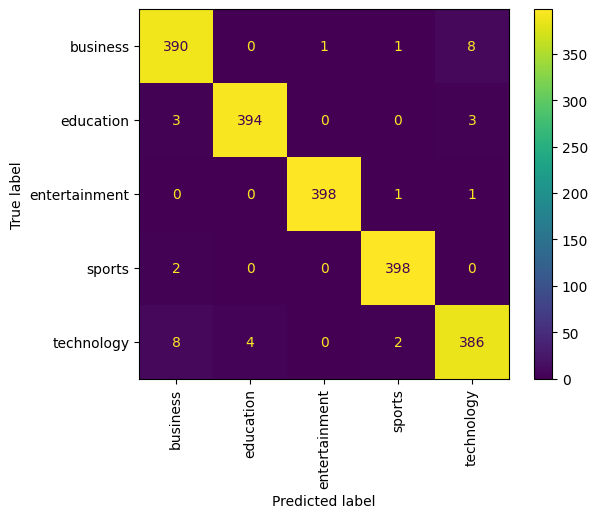

In [62]:
from sklearn import svm
model = svm.SVC(kernel='linear', class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=90)
plt.plot()


[]

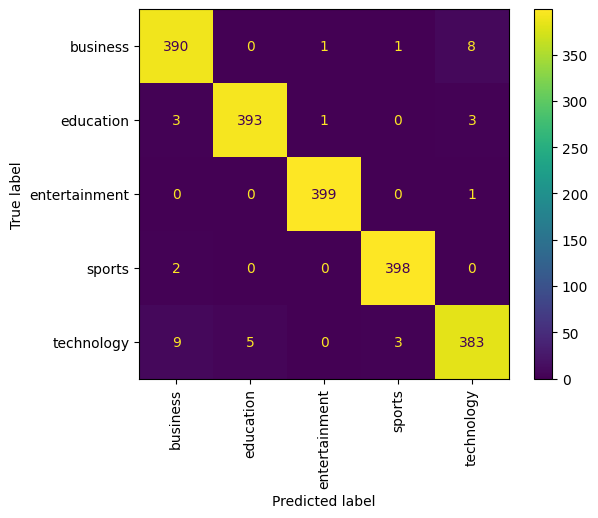

In [63]:
from sklearn import svm
model = svm.SVC(kernel='rbf', class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=90)
plt.plot()